In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns

# Download and Save Data

In [2]:
SYMBOL = "TSLA"
HISTORY = "10y"

all_day_k = yf.Ticker(SYMBOL).history(period=HISTORY, interval="1d")

# REmove meaningless columns
all_day_k = all_day_k.drop(columns=["Dividends", "Stock Splits"])

#Remove latest row
all_day_k = all_day_k[:-1]

PAST_WIN_LEN = 100
CLASSES = ["Bull", "Bear"]
LABEL_BULL = CLASSES.index("Bull")
LABEL_BEAR = CLASSES.index("Bear")

x, y = [], []
for today_i in range(len(all_day_k)):
  # Get day_k in the pass 100-day window and the forward 1-day window
  day_k_past = all_day_k[:today_i + 1]
  day_k_forward = all_day_k[today_i+1:]
  if len(day_k_past) < PAST_WIN_LEN or len(day_k_forward) < 1:
    continue
  day_k_past_win = day_k_past[-PAST_WIN_LEN:]
  day_k_forward_win = day_k_forward[:1]
  
  # Find label
  today_price = day_k_past_win.iloc[-1]["Close"]
  tomorrow_price = day_k_forward_win.iloc[0]["Close"]
  label = LABEL_BULL if tomorrow_price > today_price else LABEL_BEAR

  # Store
  x.append(day_k_past_win.values)
  y.append(label)

x, y = np.array(x), np.array(y)

# Split Dataset into Train Validation and Testing
TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT = 0.7, 0.2, 0.1

# Take the last portion to be the test dataset
test_split_index = -round(len(x) * TEST_SPLIT)
x_other, x_test = np.split(x, [test_split_index])
y_other, y_test = np.split(y, [test_split_index])

# Shuffle the remaining portion and split into training and validation datasets
train_split_index = round(len(x) * TRAIN_SPLIT)
indexes = np.arange(len(x_other))
np.random.shuffle(indexes)
train_indexes, val_indexes = np.split(indexes, [train_split_index])
x_train, x_val = x_other[train_indexes], x_other[val_indexes]
y_train, y_val = y_other[train_indexes], y_other[val_indexes]

# Balance labewls of test dataset ( Make it fair with equal amount of buy/bid label)
x_test_bull = x_test[y_test == LABEL_BULL]
x_test_bear = x_test[y_test == LABEL_BEAR]

min_n_label = min(len(x_test_bull), len(x_test_bear))

x_test_bull = x_test_bull[np.random.choice(len(x_test_bull), min_n_label, replace=False), :]
x_test_bear = x_test_bear[np.random.choice(len(x_test_bear), min_n_label, replace=False), :]
x_test = np.vstack([x_test_bull, x_test_bear])

y_test = np.array([LABEL_BULL] * min_n_label + [LABEL_BEAR] * min_n_label)

pd.DataFrame([{"Dataset": "test",
               "Bull": np.count_nonzero(y_test == LABEL_BULL),
               "Bear": np.count_nonzero(y_test == LABEL_BEAR)}])

# Show label distribution
label_distribution = pd.DataFrame([{"Dataset": "train",
                                    "Bull": np.count_nonzero(y_train == LABEL_BULL),"Bear": np.count_nonzero(y_train == LABEL_BEAR)},
                                   {"Dataset": "valid",
                                    "Bull": np.count_nonzero(y_val == LABEL_BULL),"Bear": np.count_nonzero(y_val == LABEL_BEAR)},
                                   {"Dataset": "test",
                                    "Bull": np.count_nonzero(y_test == LABEL_BULL),"Bear": np.count_nonzero(y_test == LABEL_BEAR)}])
label_distribution

# Save data

np.savez("datasets_tsla.npz", x_train=x_train, y_train=y_train, x_val = x_val, y_val = y_val, x_test = x_test, y_test = y_test)


# Construct Model
DNN

In [7]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
# Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

# print(n_time_steps)
# print(n_features)

input_layer = Input(shape=(n_time_steps, n_features))
x = Flatten()(input_layer)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
output_layer = Dense(len(CLASSES), activation="softmax")(x)

model = Model(inputs= input_layer, outputs = output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 5)]          0         
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 256)               128256    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 194562 (760.01 KB)
Trainable params: 194562 (760.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Inception

In [8]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, \
                                    BatchNormalization, Activation, \
                                    Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model


def inception_module(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding="same", activation=None,
                       use_bias=False)(bottleneck)
    conv5 = Conv1D(filters=32, kernel_size=5, padding="same", activation=None,
                       use_bias=False)(bottleneck)
    conv7 = Conv1D(filters=32, kernel_size=7, padding="same", activation=None,
                       use_bias=False)(bottleneck)
    mp = MaxPooling1D(pool_size=3, strides=1, padding="same")(input_tensor)
    mpbottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False)(mp)
    
    x = Concatenate(axis=-1)([conv3, conv5, conv7, mpbottleneck])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def shortcut_layer(input_tensor1, input_tensor2):
    shortcut = Conv1D(filters=input_tensor2.shape[-1], kernel_size=1, padding="same", activation=None,
                       use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, input_tensor2])
    x = Activation("relu")(x)
    return x

# Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer

for i in range(6):
    x = inception_module(x)
    
    if i%3==2:
        x = shortcut_layer(input_residual, x)
        input_residual = x

x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 5)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 100, 32)              160       ['input_2[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 100, 5)               0         ['input_2[0][0]']             
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 100, 32)              3072      ['conv1d[0][0]']        

InceptionTime Plus

In [9]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, \
                                    BatchNormalization, Activation, \
                                    Add, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model


def inception_module(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding="same", activation=None,
                       use_bias=False)(bottleneck)
    conv5 = Conv1D(filters=32, kernel_size=5, padding="same", activation=None,
                       use_bias=False)(bottleneck)
    conv7 = Conv1D(filters=32, kernel_size=7, padding="same", activation=None,
                       use_bias=False)(bottleneck)
    mp = MaxPooling1D(pool_size=3, strides=1, padding="same")(input_tensor)
    mpbottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False)(mp)
    
    x = Concatenate(axis=-1)([conv3, conv5, conv7, mpbottleneck])
    x = BatchNormalization()(x)
    x = Activation("LeakyReLU")(x)
    return x

def shortcut_layer(input_tensor1, input_tensor2):
    shortcut = Conv1D(filters=input_tensor2.shape[-1], kernel_size=1, padding="same", activation=None,
                       use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, input_tensor2])
    x = Activation("LeakyReLU")(x)
    return x

# Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer

for i in range(6):
    x = inception_module(x)
    x = Dropout(0.2)(x)
    
    if i%3==2:
        x = shortcut_layer(input_residual, x)
        input_residual = x

x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 5)]             0         []                            
                                                                                                  
 conv1d_32 (Conv1D)          (None, 100, 32)              160       ['input_3[0][0]']             
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 100, 5)               0         ['input_3[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d_33 (Conv1D)          (None, 100, 32)              3072      ['conv1d_32[0][0]']     

# Train Model

InceptionTime

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_checkpoint = ModelCheckpoint(filepath="best_model_tsla_dnn.hdf5", monitor="val_loss", save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]

train_history = model.fit(x_train, to_categorical(y_train, 2),
                          validation_data=(x_val, to_categorical(y_val)),
                          batch_size=2048, epochs=1000, callbacks=[callbacks])

Epoch 1/1000


2023-06-23 07:07:41.256660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 712ms/step - loss: 52424800.0000 - accuracy: 0.5142 - val_loss: 218808592.0000 - val_accuracy: 0.4886
Epoch 2/1000
1/1 [==============================] - 0s 50ms/step - loss: 218410464.0000 - accuracy: 0.4823 - val_loss: 199278688.0000 - val_accuracy: 0.4886
Epoch 3/1000


2023-06-23 07:07:41.693793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sami/code/stock_analysis/env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 72ms/step - loss: 198650576.0000 - accuracy: 0.4823 - val_loss: 108070168.0000 - val_accuracy: 0.4886
Epoch 4/1000
1/1 [==============================] - 0s 46ms/step - loss: 106311304.0000 - accuracy: 0.4823 - val_loss: 24044554.0000 - val_accuracy: 0.4824
Epoch 5/1000
1/1 [==============================] - 0s 35ms/step - loss: 22270670.0000 - accuracy: 0.5071 - val_loss: 84230544.0000 - val_accuracy: 0.5114
Epoch 6/1000
1/1 [==============================] - 0s 33ms/step - loss: 82529968.0000 - accuracy: 0.5171 - val_loss: 101523816.0000 - val_accuracy: 0.5114
Epoch 7/1000
1/1 [==============================] - 0s 33ms/step - loss: 100107864.0000 - accuracy: 0.5177 - val_loss: 87738928.0000 - val_accuracy: 0.5114
Epoch 8/1000
1/1 [==============================] - 0s 32ms/step - loss: 86046344.0000 - accuracy: 0.5171 - val_loss: 53760076.0000 - val_accuracy: 0.5093
Epoch 9/1000
1/1 [==============================] - 0s 49ms/step - loss: 51500

InceptionTime Plus

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

train_label_counts = label_distribution.iloc[0]
class_weight = {
    LABEL_BULL: 1.,
    LABEL_BEAR: train_label_counts["Bull"]/train_label_counts["Bear"]
}
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=0.00001)

model_checkpoint = ModelCheckpoint(filepath="best_model_InceptionTime_plus_tsla.hdf5", monitor="val_loss", save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping, reduce_lr]

train_history = model.fit(x_train, to_categorical(y_train),
                         validation_data=(x_val, to_categorical(y_val)),
                         batch_size=256, epochs=100, callbacks=[callbacks],
                         class_weight=class_weight)

Epoch 1/100


2023-06-21 11:12:28.812493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.8064 - accuracy: 0.4979

2023-06-21 11:12:36.643162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 13s 1s/step - loss: 0.8064 - accuracy: 0.4979 - val_loss: 1.6580 - val_accuracy: 0.5197 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 3s 442ms/step - loss: 0.7599 - accuracy: 0.4979 - val_loss: 0.9939 - val_accuracy: 0.5197 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 3s 385ms/step - loss: 0.7435 - accuracy: 0.4973 - val_loss: 1.7139 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 3s 396ms/step - loss: 0.7384 - accuracy: 0.5062 - val_loss: 0.7433 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 3s 431ms/step - loss: 0.7403 - accuracy: 0.4950 - val_loss: 0.7306 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 3s 433ms/step - loss: 0.7485 - accuracy: 0.5204 - val_loss: 0.7347 - val_accuracy: 0.5010 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 2s 350ms/step - loss: 0.7465 - accuracy

# Evaluation

Inception

In [18]:
#TSLA
model.evaluate(x_train, to_categorical(y_train))
model.evaluate(x_val, to_categorical(y_val))
model.evaluate(x_test, to_categorical(y_test))

7/7 [==============================] - 1s 100ms/step - loss: 0.6902 - accuracy: 0.5090


[0.6901620626449585, 0.5090090036392212]

In [20]:
# SOFI
model.evaluate(x_train, to_categorical(y_train))
model.evaluate(x_val, to_categorical(y_val))
model.evaluate(x_test, to_categorical(y_test))

2/2 [==============================] - 0s 80ms/step - loss: 0.7006 - accuracy: 0.5000


[0.7006212472915649, 0.5]

In [ ]:
#AAPL
model.evaluate(x_train, to_categorical(y_train))
model.evaluate(x_val, to_categorical(y_val))
model.evaluate(x_test, to_categorical(y_test))

8/8 [==============================] - 1s 146ms/step - loss: 0.7116 - accuracy: 0.5000


[0.7116483449935913, 0.5]

InceptionTime Plus

In [13]:
#TSLA
model.evaluate(x_train, to_categorical(y_train))
model.evaluate(x_val, to_categorical(y_val))
model.evaluate(x_test, to_categorical(y_test))

8/8 [==============================] - 0s 23ms/step - loss: 0.6933 - accuracy: 0.5128


[0.6932727694511414, 0.5128205418586731]

In [12]:
#AAPL
model.evaluate(x_train, to_categorical(y_train))
model.evaluate(x_val, to_categorical(y_val))
model.evaluate(x_test, to_categorical(y_test))

8/8 [==============================] - 1s 73ms/step - loss: 0.6933 - accuracy: 0.5128


[0.6932727694511414, 0.5128205418586731]

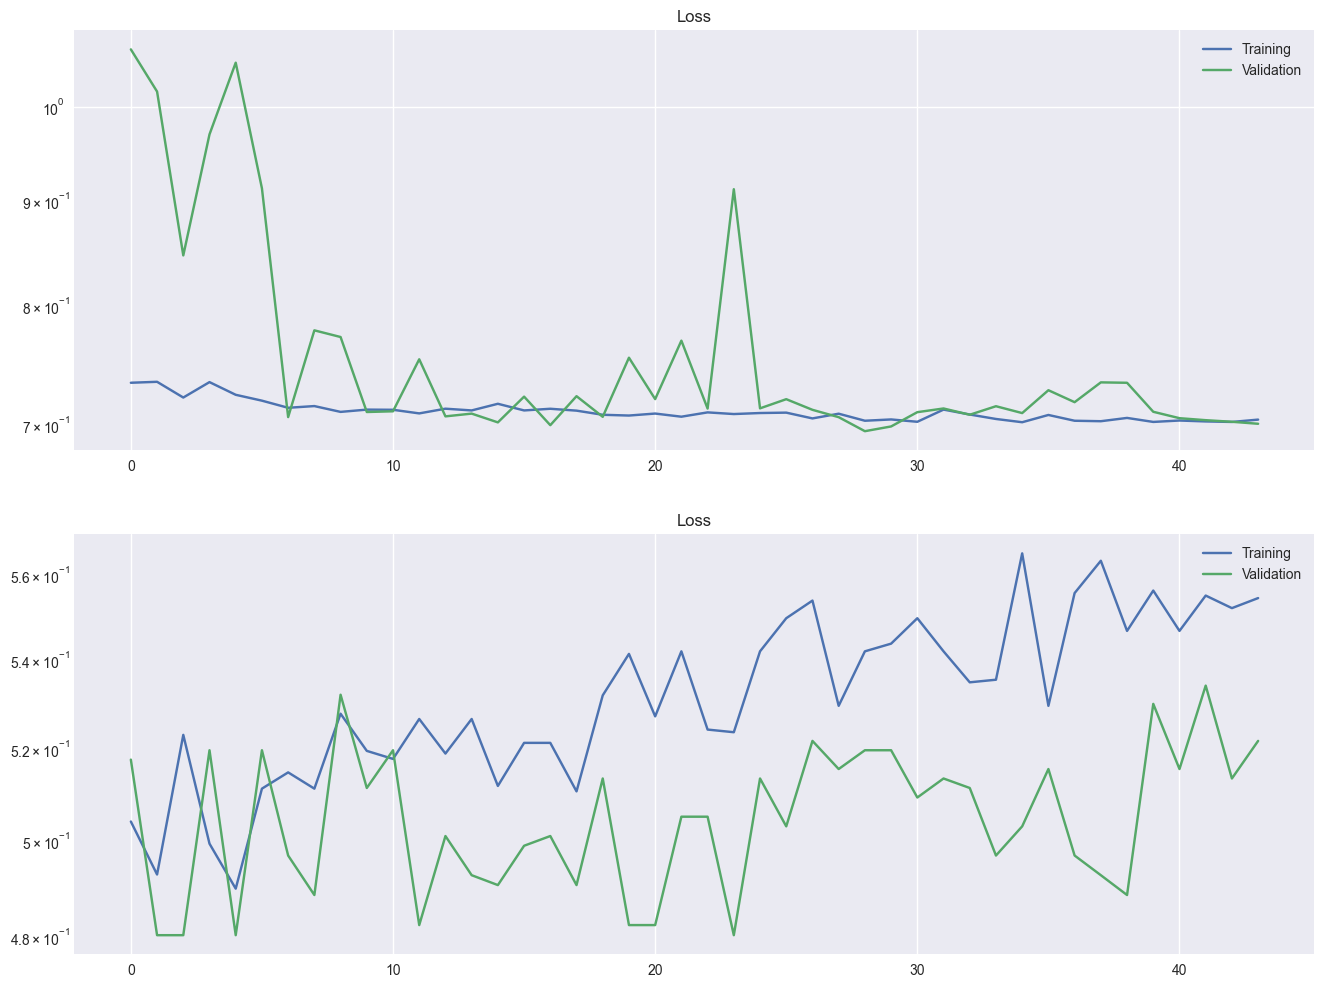

In [ ]:
import matplotlib.pyplot as plt

#TSLA
plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].set_title("Loss")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label="Training")
axes[0].plot(train_history.history["val_loss"], label="Validation")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].set_yscale("log")
axes[1].plot(train_history.history["accuracy"], label="Training")
axes[1].plot(train_history.history["val_accuracy"], label="Validation")
axes[1].legend()

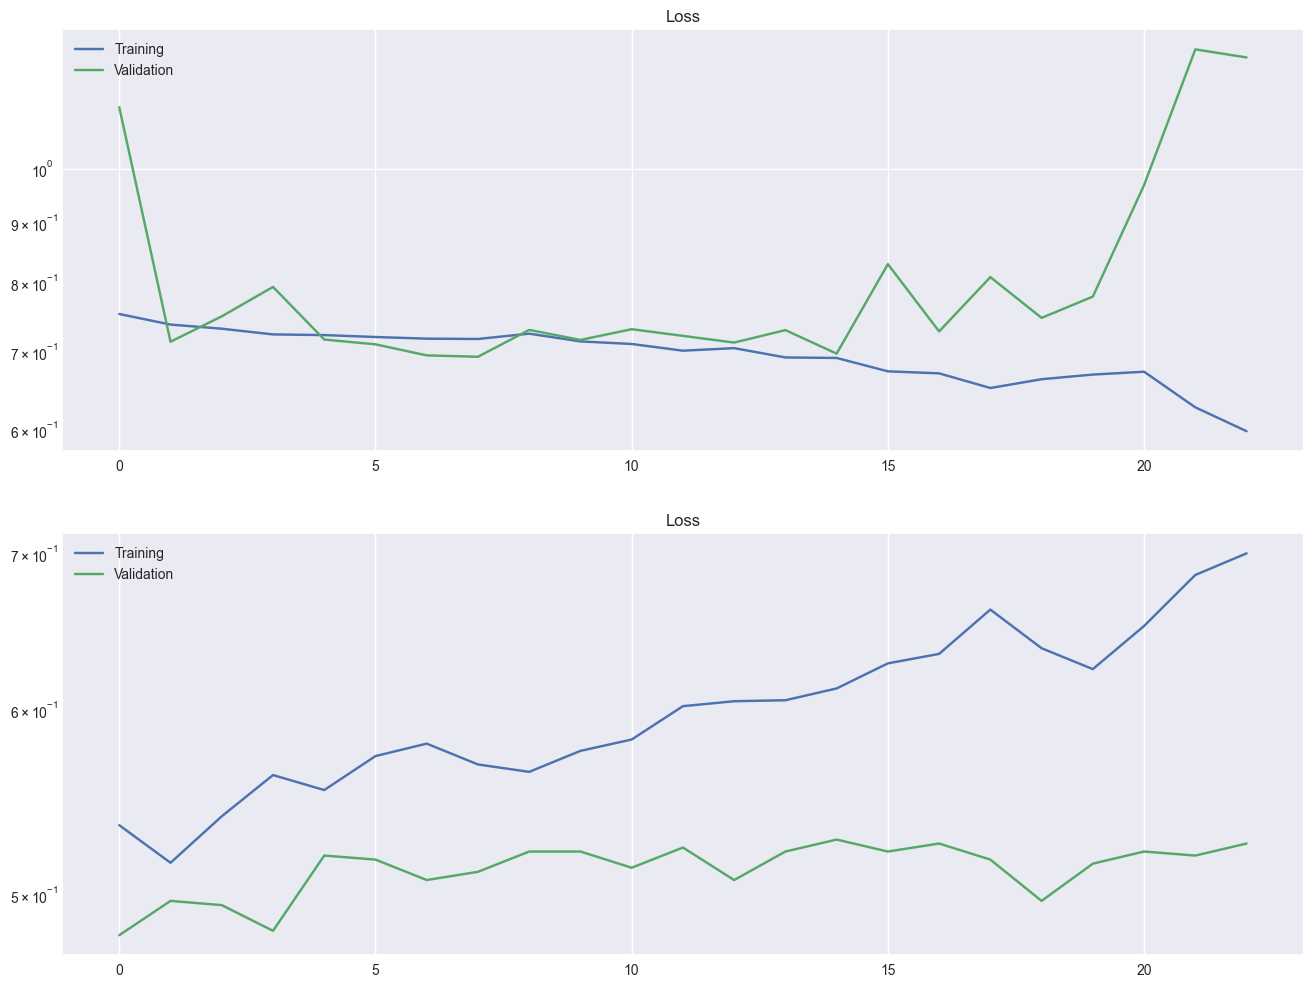

In [ ]:
import matplotlib.pyplot as plt

#AAPL
plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].set_title("Loss")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label="Training")
axes[0].plot(train_history.history["val_loss"], label="Validation")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].set_yscale("log")
axes[1].plot(train_history.history["accuracy"], label="Training")
axes[1].plot(train_history.history["val_accuracy"], label="Validation")
axes[1].legend()

# Load and Evaluate

In [5]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

MODEL = "best_model_tsla_inceptiontimeplus.hdf5"

model = keras.models.load_model(MODEL)

2023-06-23 07:05:25.122791: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-06-23 07:05:25.122811: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-23 07:05:25.122815: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-23 07:05:25.122928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-23 07:05:25.123202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Load Data

In [3]:
import numpy as np
import pandas as pd

PAST_WIN_LEN = 100
CLASSES = ["Bull", "Bear"]
LABEL_BULL = CLASSES.index("Bull")
LABEL_BEAR = CLASSES.index("Bear")

datasets = np.load("datasets_tsla.npz")
x_train, y_train = datasets["x_train"], datasets["y_train"]
x_val, y_val = datasets["x_val"], datasets["y_val"]
x_test, y_test = datasets["x_test"], datasets["y_test"]

# Label distrubition
label_distribution = pd.DataFrame([
    {
        "Dataset": "train",
        "Bull": np.count_nonzero(y_train==LABEL_BULL),
        "Bear": np.count_nonzero(y_train==LABEL_BEAR),
    },
    {
        "Dataset": "val",
        "Bull": np.count_nonzero(y_val==LABEL_BULL),
        "Bear": np.count_nonzero(y_val==LABEL_BEAR),
    },
    {
        "Dataset": "test",
        "Bull": np.count_nonzero(y_test==LABEL_BULL),
        "Bear": np.count_nonzero(y_test==LABEL_BEAR),
    }
])
label_distribution

,Dataset,Bull,Bear
0,train,876,816
1,val,247,236
2,test,111,111


16/16 [==============================] - 0s 1ms/step


2023-06-23 07:11:26.882669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


,Prediction,Accuracy
0,Bull,0.495763
1,Bear,0.473684
2,Total,0.484472


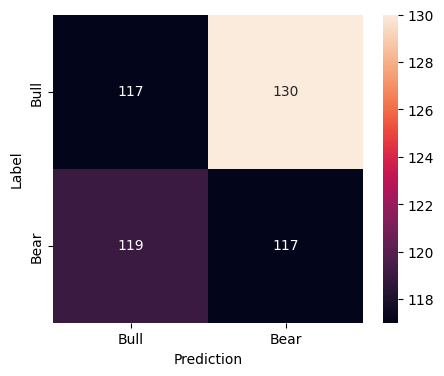

In [9]:
x_test, y_test = x_val, y_val

model.evaluate(x_test, to_categorical(y_test))

# Draw confusion matrix
from tensorflow.math import argmax, confusion_matrix

y_pred_prob = model.predict(x_test)
y_pred = argmax(y_pred_prob, axis=-1)
cm = confusion_matrix(y_test, y_pred, num_classes=len(CLASSES)).numpy()


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm, xticklabels=CLASSES, yticklabels=CLASSES, annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Label")


n_bull_pred = cm[LABEL_BULL, LABEL_BULL] + cm[LABEL_BEAR, LABEL_BULL]
n_bull_true_pos = cm[LABEL_BULL, LABEL_BULL]
bull_accuracy = n_bull_true_pos / n_bull_pred if n_bull_pred >0 else 0

n_bear_pred = cm[LABEL_BULL, LABEL_BEAR] + cm[LABEL_BEAR, LABEL_BEAR]
n_bear_true_pos = cm[LABEL_BEAR, LABEL_BEAR]
bear_accuracy = n_bear_true_pos / n_bear_pred if n_bear_pred >0 else 0

n_total_pred = n_bull_pred + n_bear_pred
n_total_true_pos = n_bull_true_pos + n_bear_true_pos
total_accuracy = n_total_true_pos / n_total_pred if n_total_pred > 0 else 0

pd.DataFrame([
    {"Prediction": "Bull", "Accuracy": bull_accuracy},
    {"Prediction": "Bear", "Accuracy": bear_accuracy},
    {"Prediction": "Total", "Accuracy": total_accuracy}
])
